In [2]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import os
import _pickle as cPickle

def test_significance(nomon_data, rowcol_data):
    shapiro_stat, shapiro_p = stats.shapiro(nomon_data - rowcol_data)
    
    if shapiro_p <= 0.05:
        print("Normality Assumption Violated. Running Wilcoxin", shapiro_stat, shapiro_p)
        
        Z_stat, p_value = stats.wilcoxon(nomon_data-rowcol_data)
        r = Z_stat / (len(nomon_data)*(len(nomon_data)+1)/2)
        return {"Z": Z_stat, "r": r, "p": p_value}
    else:
        print("Running Dependant T test")
        t_stat, p_value = stats.ttest_rel(nomon_data, rowcol_data)
        df = len(nomon_data)-1
        r = np.sqrt(t_stat**2/(t_stat**2+df))
        return {"t": t_stat, "r": r, "p": p_value}

def save_pvalues(dict):
    pickle_path = 'D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/pvalues.pkl'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as fp:
            pvalue_dict = cPickle.load(fp)
    else:
        pvalue_dict = {}
    
    for key in dict.keys():
        pvalue_dict[key] = dict[key]
     
    with open(pickle_path, 'wb') as fp:
        cPickle.dump(pvalue_dict, fp)

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDBnew"
)

df = pd.read_sql('SELECT * FROM tlx_info', con=mydb)

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]
users=[98, 133, 140, 161, 168, 175, 182, 196, 231, 238, 245, 252, 259]
df = df[(df.id >= 98) & (df.id != 126) & (df.id != 217)].drop_duplicates()
df = df[df["id"].isin(users)].drop_duplicates()

columns = list(df.columns)
weight_columns = list(df.columns[10:])
load_columns = list(df.columns[4:10])
load_sources = ["Mental", "Physical", "Temporal", "Performance", "Effort", "Frustration"]

df.performance_load = 20-df.performance_load


In [3]:
unweighted_filter = df[df["session"] == 5]
for row in unweighted_filter.values:
    id, software = row[:2]
    weight_values = df[(df.session == 2) & (df.software == software) & (df.id == id)][weight_columns]
    df.loc[((df.session == 5) & (df.software == software) & (df.id == id)), weight_columns] = weight_values.values

In [7]:

df["tlx"] = np.sum(df[load_columns].values*5*df[weight_columns].values, axis=1)/15

nomon_tlx = {}
rowcol_tlx = {}
for session in list(set(df.session.values)):
    nomon_tlx[session] = {"avg": np.median(df[(df.software == "A") & (df.session == session)].tlx.values),
                          "std": np.std(df[(df.software == "A") & (df.session == session)].tlx.values)}
    rowcol_tlx[session] = {"avg": np.median(df[(df.software == "B") & (df.session == session)].tlx.values),
                           "std": np.std(df[(df.software == "B") & (df.session == session)].tlx.values)}

27.025641025641026 33.35897435897436 13
Running Dependant T test
9 {'t': -2.432700718725024, 'r': 0.5747030738179585, 'p': 0.03157631304284018} 

41.35897435897436 34.64102564102564 13
Running Dependant T test
2 {'t': 1.3082187645743515, 'r': 0.3532961448261618, 'p': 0.21530348190766238} 

27.17948717948718 27.666666666666668 13
Running Dependant T test
10 {'t': -0.22057264360097162, 'r': 0.06354515050167221, 'p': 0.8291333802520733} 

33.43589743589743 31.923076923076927 13
Running Dependant T test
5 {'t': 0.34372301719870757, 'r': 0.09873941135712386, 'p': 0.7370021051590807} 

{'Session 9 tlx': {'t': -2.432700718725024, 'r': 0.5747030738179585, 'p': 0.03157631304284018}, 'Session 2 tlx': {'t': 1.3082187645743515, 'r': 0.3532961448261618, 'p': 0.21530348190766238}, 'Session 10 tlx': {'t': -0.22057264360097162, 'r': 0.06354515050167221, 'p': 0.8291333802520733}, 'Session 5 tlx': {'t': 0.34372301719870757, 'r': 0.09873941135712386, 'p': 0.7370021051590807}}


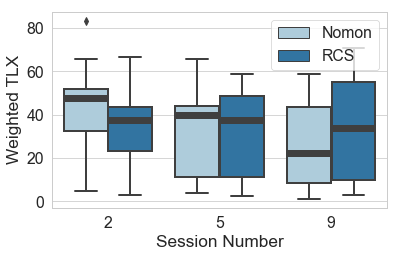

In [8]:
sns.set_context("paper", font_scale=1.8)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

a4_dims = (6, 4)
fig, ax = plt.subplots(figsize=a4_dims)
plt.subplots_adjust(bottom=0.2)

tlx_df = df[["tlx", "software", "session", "id"]].rename(columns={"tlx": "Weighted TLX", "software": "Keyboard", "session": "Session Number", "id": "id"})
tlx_df = tlx_df.sort_values(by=['id', "Keyboard"])
tlx_df = tlx_df.replace("A", "Nomon")
tlx_df = tlx_df.replace("B", "RCS")


box_plot = sns.boxplot(data=tlx_df[tlx_df["Session Number"] < 10], x="Session Number", y="Weighted TLX", hue="Keyboard", ax=ax, linewidth=2)

ax = box_plot.axes
ax.get_legend().set_title('')
lines = ax.get_lines()

for median_line in lines[4:len(lines):6]:
    median_line.set_solid_capstyle('butt')
    median_line.set_linewidth(7)
    median_line.set_alpha(1)

pvalues = {}
for session in list(set(df.session.values)):
    nomon_data = tlx_df[(tlx_df.Keyboard == "Nomon") & (tlx_df["Session Number"] == session)][["id","Weighted TLX"]]
    nomon_data = nomon_data.sort_values(by=['id'])["Weighted TLX"].values
    rowcol_data = tlx_df[(tlx_df.Keyboard == "RCS") & (tlx_df["Session Number"] == session)][["id","Weighted TLX"]]
    rowcol_data = rowcol_data.sort_values(by=['id'])["Weighted TLX"].values
    
    print(np.mean(nomon_data), np.mean(rowcol_data), len(rowcol_data))
    
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(session, cur_pvalue, "\n")
    pvalues["Session "+str(session)+" tlx"] = cur_pvalue

# save_pvalues(pvalues)
print(pvalues)

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/AB_study/figures/tlx.png", dpi=300)


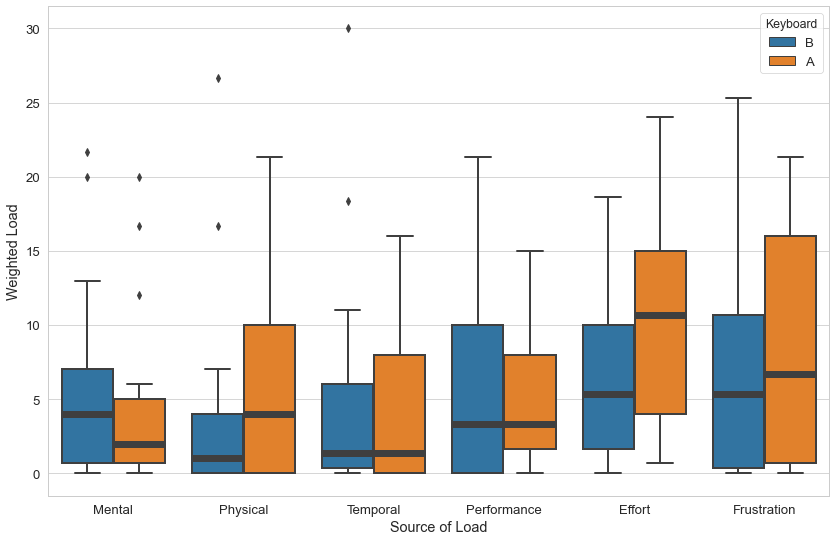

In [6]:
load_df = pd.DataFrame(columns=["Source of Load", "Keyboard", "Weighted Load"])
for row in df[df.session == 2].values:
    for load, weight, source in zip(load_columns, weight_columns, load_sources):
        weight_index = columns.index(weight)  
        load_index = columns.index(load)
        software_index = columns.index("software")
        
        load_df = load_df.append({"Source of Load": source, 
                        "Keyboard": row[software_index], 
                        "Weighted Load": row[load_index]*5*row[weight_index]/15}, ignore_index=True)

a4_dims = (14, 9)
fig, ax = plt.subplots(figsize=a4_dims)

box_plot = sns.boxplot(data=load_df, x="Source of Load", y="Weighted Load", hue="Keyboard", ax=ax, linewidth=2)

ax = box_plot.axes
lines = ax.get_lines()

for median_line in lines[4:len(lines):6]:
    median_line.set_solid_capstyle('butt')
    median_line.set_linewidth(7)
    median_line.set_alpha(1)

,id,software,tlx
46,98,A,31.333333
47,98,B,55.000000
122,133,B,3.000000
123,133,A,1.333333
121,140,A,22.333333
124,140,B,33.333333
147,168,A,5.000000
146,168,B,11.333333
139,175,A,53.333333
142,175,B,70.666667
